In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import platform
from pandas.core.common import SettingWithCopyWarning

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Warning 제거
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning) 
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [66]:
df = pd.read_csv(r'data\Airplane_Crashes_and_Fatalities_Since_1908.csv')
city = pd.read_csv(r'data\worldcities.csv')
world = pd.read_csv(r'data\number-of-air-transport-passengers.csv')


In [67]:
df_edit = df.copy()

* Yearly how many planes crashed? how many people were on board? how many survived? how many died?
* Highest number of crashes by operator and Type of aircrafts.
* ‘Summary’ field has the details about the crashes. Find the reasons of the crash and categorize them in different clusters i.e Fire, shot down, weather (for the ‘Blanks’ in the data category can be UNKNOWN) you are open to make clusters of your choice but they should not exceed 7.
* Find the number of crashed aircrafts and number of deaths against each category from above step.
* Find any interesting trends/behaviors that you encounter when you analyze the dataset.

# pre-processing

In [68]:
df_edit.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


In [69]:
df_edit[df_edit['Ground']>=100]

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
2091,12/24/1966,19:15,"Binh Tahi, Da Nang, Vietnam",Flying Tiger Line,NaN,NaN,Canadair CL-44D4-1,N228SW,31,4.0,4.0,107.0,The cargo plane undershot runway by 1 mile whi...
2933,10/13/1976,NaN,"Santa Cruz, Bolivia",Lloyd Aéreo Boliviano,NaN,Santa Cruz - Viru,Boeing B-707-31,N730JP,17671/48,3.0,3.0,113.0,The aircraft failed to climb and crashed into ...
4390,01/08/1996,12:43,"Kinshasa, Zaire",African Air,NaN,Kinshasa - Kahemba,Antonov AN-32B,RA-26222,2301,6.0,2.0,225.0,The aircraft failed to gain altitude after tak...
4802,09/11/2001,09:45,"Arlington, Virginia.",American Airlines,77,Washington D.C. - Los Angeles,Boeing B-757-223,N644AA,24602/365,64.0,64.0,125.0,The aircraft was hijacked after taking off fro...
4803,09/11/2001,08:47,"New York City, New York",American Airlines,11,Boston - Los Angeles,Boeing 767-223ER,N334AA,22332/169,92.0,92.0,2750.0,The aircraft was hijacked shortly after it lef...
4804,09/11/2001,09:03,"New York City, New York",United Air Lines,175,Boston - Los Angeles,Boeing B-767-222,N612UA,21873/41,65.0,65.0,2750.0,The aircraft was hijacked shortly after it lef...


In [70]:
df_edit.isnull().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64

In [71]:
df_edit = df_edit.dropna(subset = ['Location', 'Operator', 'Type', 'Aboard', 'Fatalities', 'Ground','Summary'])   

In [72]:
df_edit[['Aboard', 'Fatalities', 'Ground']] = df_edit[['Aboard', 'Fatalities', 'Ground']].astype('int64') 

In [73]:
df_edit['Date'] = df_edit['Date'].astype('datetime64') 
df_edit['Year'] = df_edit['Date'].dt.year

In [74]:
df = df_edit.reset_index(drop=True)

In [75]:
df

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2,1,0,"During a demonstration flight, a U.S. Army fly...",1908
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5,5,0,First U.S. dirigible Akron exploded just offsh...,1912
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1,1,0,The first fatal airplane accident in Canada oc...,1913
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20,14,0,The airship flew into a thunderstorm and encou...,1913
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30,30,0,Hydrogen gas which was being vented was sucked...,1913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809,2009-05-03,12:00,"Near El Alto de Rubio, Venezuela",Military - Venezuelan Army,NaN,Patrol,Mi-35,EV08114,NaN,18,18,0,The helicopter was patrolling along the Venezu...,2009
4810,2009-05-20,06:30,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112,98,2,"While on approach, the military transport cras...",2009
4811,2009-06-01,00:15,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228,228,0,The Airbus went missing over the AtlantiOcean ...,2009
4812,2009-06-07,08:30,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1,1,0,The air ambulance crashed into hills while att...,2009


In [76]:
len(df)

4814

In [77]:
df.nunique()

Date            4351
Time            1000
Location        3960
Operator        2361
Flight #         720
Route           3197
Type            2307
Registration    4548
cn/In           3568
Aboard           238
Fatalities       191
Ground            48
Summary         4614
Year              98
dtype: int64

# processing & visualising

## 년도별 사망률(총 항공여객수 대비)

<AxesSubplot:xlabel='Year', ylabel='Fatal_Ratio_percent'>

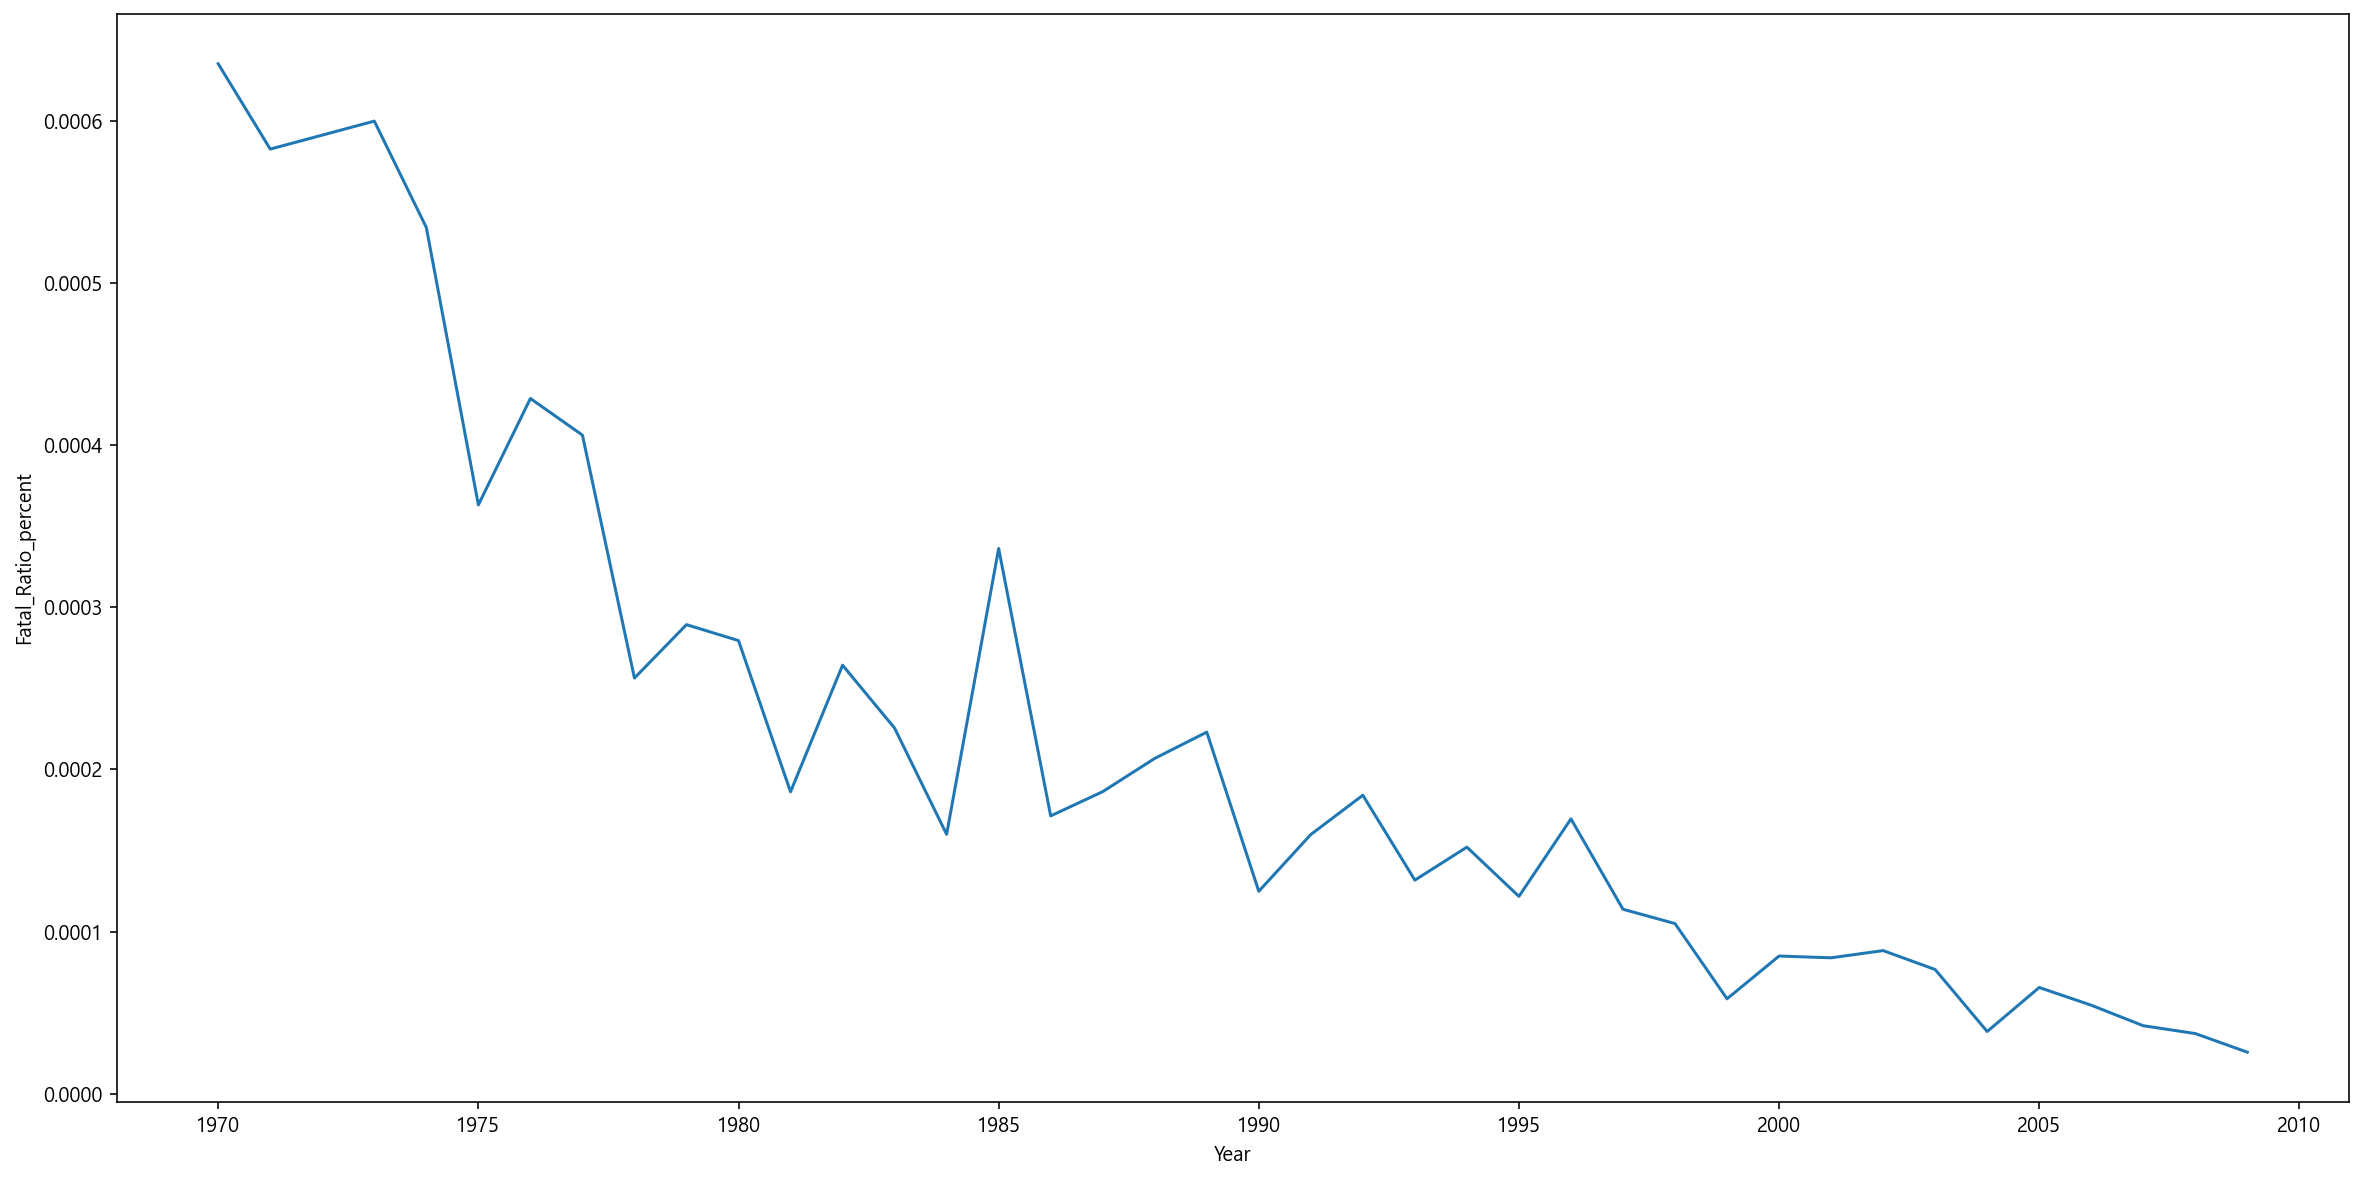

In [78]:
df_year_sum = df.groupby(['Year'],as_index=False).agg(Date_yr_sum = ('Fatalities','sum'))
df_year_sum_1970 = df_year_sum[df_year_sum['Year']>=1970]

world = world[['Year','Air transport, passengers carried']]
world = world[world['Year']<=2009]

df_year_sum_1970 = pd.merge(df_year_sum_1970,world,on='Year')
df_year_sum_1970['Fatal_Ratio_percent'] = df_year_sum_1970['Date_yr_sum'] / df_year_sum_1970['Air transport, passengers carried'] * 100

fig = plt.figure(figsize = (20 ,10))
sns.lineplot(data = df_year_sum_1970, x='Year', y='Fatal_Ratio_percent')

## 제조사별 사망자합 top 10

In [79]:
df['Type_manu'] = df['Type'].apply(lambda x : x.split(' ')[0])
df.groupby(['Type_manu'],as_index=False).agg(Type_manu_sum = ('Fatalities','sum')).sort_values(by='Type_manu_sum',ascending=False).head(10)

,Type_manu,Type_manu_sum
45,Boeing,18450
92,Douglas,16071
166,Lockheed,7363
176,McDonnell,6932
16,Antonov,5853
255,Tupolev,5773
145,Ilyushin,4449
12,Airbus,2811
271,de,2758
112,Fokker,2640


In [80]:
import plotly.graph_objects as go
ratio_total   = list(df.groupby(['Type_manu'],as_index=False).agg(Type_manu_sum = ('Fatalities','sum')).sort_values(by='Type_manu_sum',ascending=False).head(10).loc[:,'Type_manu_sum'])
labels_total  = list(df.groupby(['Type_manu'],as_index=False).agg(Type_manu_sum = ('Fatalities','sum')).sort_values(by='Type_manu_sum',ascending=False).head(10).loc[:,'Type_manu'])

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels_total, values=ratio_total)])
fig.update_layout(margin=dict(t=20, b=20, l=10, r=20))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## millitary , public 구분해서

In [81]:
df_mil = df[df['Operator'].str.contains('Military')]
df_pub = df[~df['Operator'].str.contains('Military')]

df_mil['m/p'] = 'Military'
df_pub['m/p'] = 'Public'

df = pd.concat([df_mil,df_pub]).reset_index()

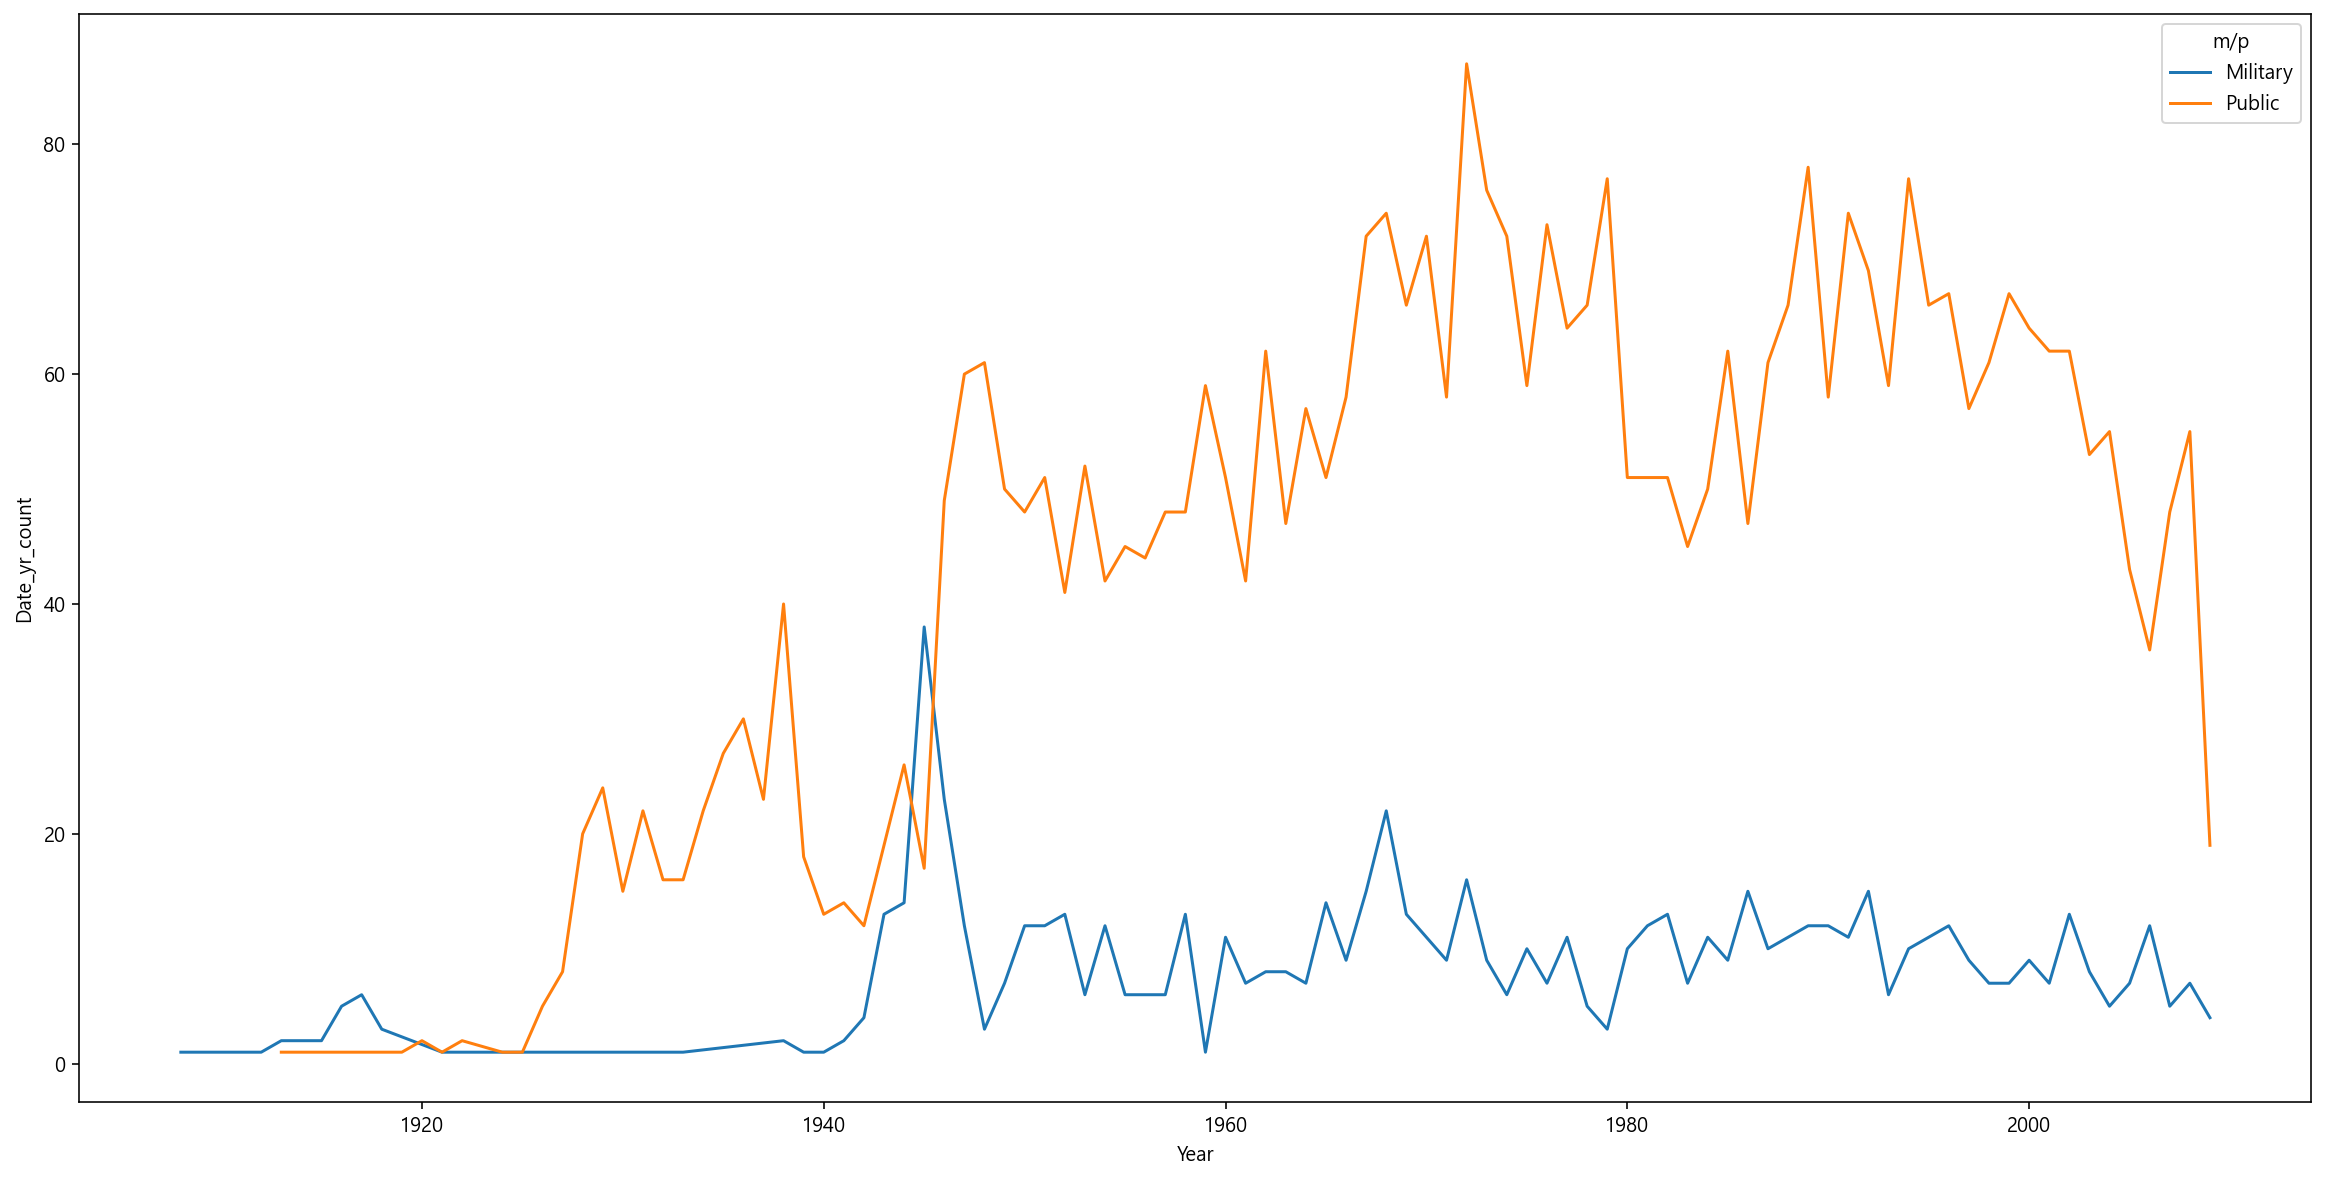

In [82]:
fig = plt.figure(figsize = (20 ,10))
sns.lineplot(data = df.groupby(['Year','m/p'],as_index=False).agg(Date_yr_count = ('Fatalities','count')) , x='Year',y='Date_yr_count', hue='m/p')
plt.show()

## 항공경로 그리기

In [83]:
df_edit_route = df_edit.dropna(subset=['Route'])

df_edit_route_split0 = df_edit_route[df_edit_route['Route'].str.count(' - ')==0]    # 시험비행 등 출발도시,도착도시 없는 로우
df_edit_route_split1 = df_edit_route[df_edit_route['Route'].str.count(' - ')==1]    # 출발도시,도착도시 
df_edit_route_split2 = df_edit_route[df_edit_route['Route'].str.count(' - ')==2]    # 출발도시,경유도시,도착도시 

print(len(df_edit_route))
print(len(df_edit_route_split0))
print(len(df_edit_route_split1))
print(len(df_edit_route_split2))

3503
217
3032
205


In [84]:
# 출발도시, 도착도시 만 있는 df_edit_route_split1 만 보자.
df_edit_route_split1['dep_city'] = df_edit_route_split1['Route'].apply(lambda x : x.split(' - ')[0]).apply(lambda x : x.split(',')[0])
df_edit_route_split1['arr_city'] = df_edit_route_split1['Route'].apply(lambda x : x.split(' - ')[1]).apply(lambda x : x.split(',')[0])
df_air = df_edit_route_split1

In [85]:
city = city[['city','lng','lat']]
# 미국에도 파리가 있더라
city = city.drop_duplicates(['city'], keep='first')

dep_city = city.copy()
dep_city = dep_city.rename(columns={'city':'dep_city','lng':'dep_lng','lat':'dep_lat'})

arr_city = city.copy()
arr_city = arr_city.rename(columns={'city':'arr_city','lng':'arr_lng','lat':'arr_lat'})

In [86]:
df_air = pd.merge(left= df_air,right = dep_city, on='dep_city')
df_air = pd.merge(left= df_air,right = arr_city, on='arr_city')
df_air.reset_index(drop=True)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year,dep_city,arr_city,dep_lng,dep_lat,arr_lng,arr_lat
0,1923-12-23,02:30,Over the Mediterranean Sea,Military - French Navy,NaN,Toulon - Algiers,Zeppelin Dixmunde (airship),L-72,NaN,52,52,0,"Crashed while on a flight from Toulon, France ...",1923,Toulon,Algiers,5.9306,43.1258,3.0586,36.7764
1,2003-02-07,NaN,"Near Agadir, Morocco",Volare Aviation Enterprise,NaN,Agadir - Algiers,Antonov 12BP,UR-LIP,9346405,8,8,0,"Crashed in the Atlas mountain range at 9,900 f...",2003,Agadir,Algiers,-9.5833,30.4167,3.0586,36.7764
2,2003-03-06,15:45,"Tamanrasset, Algeria",Air Algerie,6289,Tamanrasset - Algiers,Boeing B-737-2T4,7T-VEZ,22700/885,103,102,0,The starboard engine caught fire and failed wh...,2003,Tamanrasset,Algiers,5.5228,22.7850,3.0586,36.7764
3,1926-07-03,NaN,"Rossaugpt, Czechoslovakia",Compagnie Internationale de Navigation Aérienne,NaN,Paris - Prague,Caudron C-61,F-AFBT,5307,7,7,0,Crashed while en route.,1926,Paris,Prague,2.3522,48.8566,14.4167,50.0833
4,1950-02-27,NaN,"Near Prague, Czechoslovakia",Ceskoslovenske Aerolinie,NaN,Ostrava - Prague,Douglas C-47A-15-DK,OK-WDY,12725,5,5,0,The aircraft crashed into a mountain while en ...,1950,Ostrava,Prague,18.2925,49.8356,14.4167,50.0833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,2007-06-25,10:40,"Near Sihanoukville, Cambodia",PMT Air,241,Siem Reap - Sihanoukville,Antonov AN-24V,XU-U4A,99901908,22,22,0,The aircraft crashed into Phnom Damrey Mountai...,2007,Siem Reap,Sihanoukville,103.8597,13.3622,103.5000,10.6333
1438,2007-08-26,16:00,"Kongolo, DemocratiRepubliCongo",Great Lakes Business Complany,NaN,Kongolo - Goma,Antonov AN-32,9Q-CAC,14-07,15,14,0,"The cargo plane, carrying tin ore, lost one of...",2007,Kongolo,Goma,26.9800,-5.3795,29.2336,-1.6794
1439,2007-10-07,20:00,"White Pass, Washington",Kapowsin Air Sports,NaN,"Star, ID - Shelton, WA",Cessna 208 Caravan,N430A,208B0415,10,10,0,The parachutists had gone to Boise for a skydi...,2007,Star,Shelton,-116.4934,43.7013,-73.1383,41.3060
1440,2008-06-07,14:00,"Yeco, Chile",Patagonia Airlines,NaN,Puerto Montt - La Junta,Cessna 208 Grand Caravan,CC-CTR,208B-1137,10,10,0,The air taxi crashed about 18 km from its dest...,2008,Puerto Montt,La Junta,-72.9396,-41.4718,-107.3317,28.4778


In [87]:
# 주의! head()늘리면 컴 터짐
number = 100

import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [df_air.head(1).loc[0,'dep_lng'], df_air.head(1).loc[0,'arr_lng']],
    lat = [df_air.head(1).loc[0,'dep_lat'], df_air.head(1).loc[0,'arr_lat']],
    marker = {'size': 5}))
for i in range(1,len(df_air.head(number))):
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [df_air.loc[i,'dep_lng'], df_air.loc[i,'arr_lng']],
        lat = [df_air.loc[i,'dep_lat'], df_air.loc[i,'arr_lat']],
        marker = {'size': 5}))

fig.update_layout(
    margin = {'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': 0, 'lat': 20},
        'style': "stamen-terrain",
        'center': {'lon': 0, 'lat': 20},
        'zoom': 1.5})
fig.show()

## 사고장소

In [88]:
df_loc = df.copy()

df_loc['loc'] = df_loc['Location'].apply(lambda x : x.split(',')[0]).str.replace('Near ','')
loc_city = city.copy()
loc_city = loc_city.rename(columns={'city':'loc','lng':'loc_lng','lat':'loc_lat'})
df_loc = pd.merge(left= df_loc,right = loc_city, on='loc')

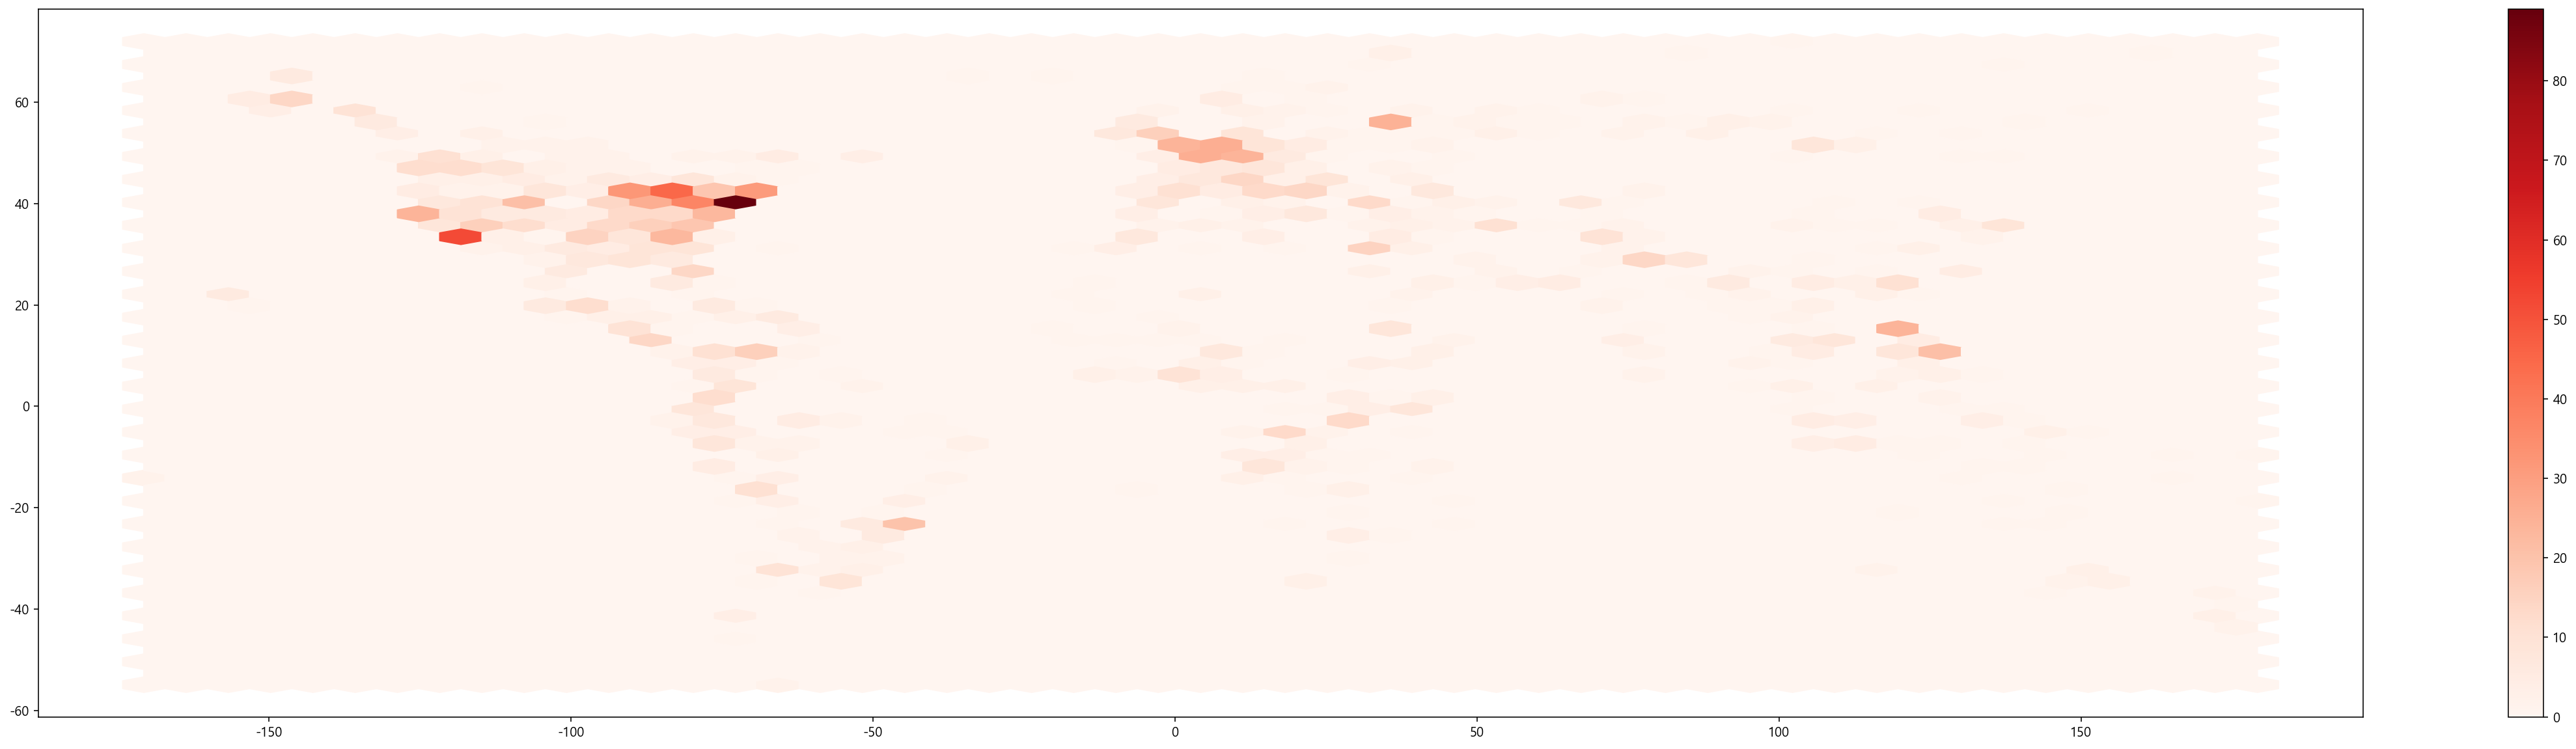

In [89]:
plt.figure(figsize=(40,10))

plt.hexbin(df_loc['loc_lng'],df_loc['loc_lat'], cmap='Reds', gridsize=50)
plt.colorbar()

plt.show()

## 원인 분석

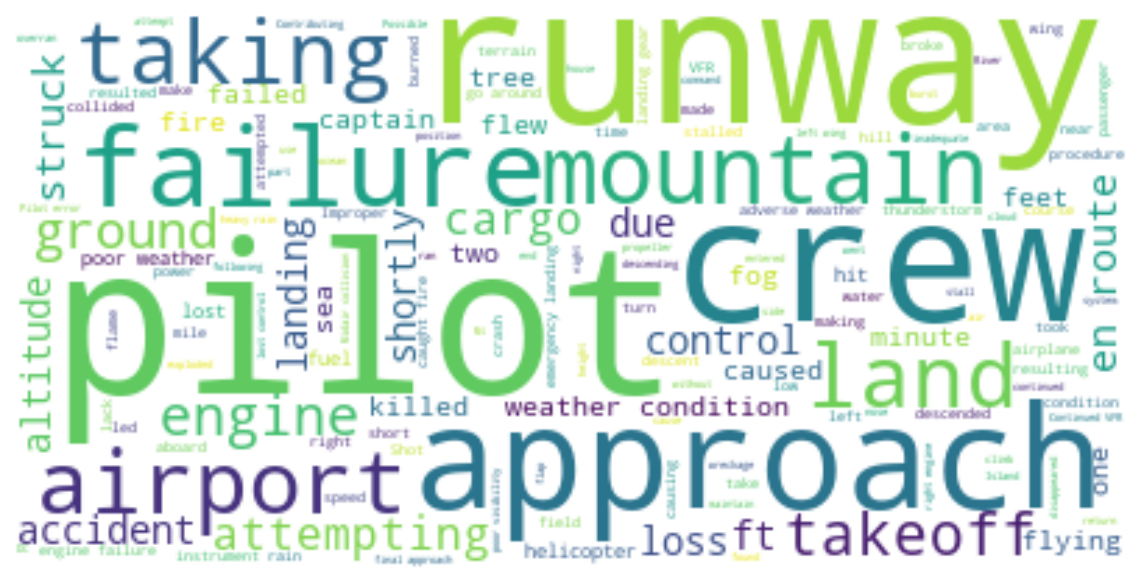

In [90]:
from wordcloud import WordCloud, STOPWORDS

text = str(df.Summary.tolist())

stopwords = set(STOPWORDS)
stopwords.add('crashed')
stopwords.add('aircraft')
stopwords.add('flight')
stopwords.add('plane')

wc = WordCloud(background_color="white", max_words=2000, stopwords=stopwords)
wc.generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
df['why'] = np.nan

df[df['Summary'].str.contains('whether')]['why'] = 'whether'
df[df['Summary'].str.contains('fuel')]['why'] = 'fuel'
df[df['Summary'].str.contains('control')]['why'] = 'control'
df[df['Summary'].str.contains('hijack')]['why'] = 'hijacking'
df[df['Summary'].str.contains('altitude')]['why'] = 'altitude'
df[df['Summary'].str.contains('engine')]['why'] = 'engine'
df[df['Summary'].str.contains('pilot')]['why'] = 'pilot'
df[df['Summary'].str.contains('crew')]['why'] = 'crew'
df[df['Summary'].str.contains('land|approach')]['why'] = 'landing'
df[df['Summary'].str.contains('tak')]['why'] = 'takeoff'

In [92]:
df_1 = df[df['Summary'].str.contains('whether')]
df_1['why'] = 'whether'
df_2 = df[df['Summary'].str.contains('fuel')]
df_2['why'] = 'fuel'
df_3 = df[df['Summary'].str.contains('control')]
df_3['why'] = 'control'
df_4 = df[df['Summary'].str.contains('hijack')]
df_4['why'] = 'hijack'
df_5 = df[df['Summary'].str.contains('altitude')]
df_5['why'] = 'altitude'
df_6 = df[df['Summary'].str.contains('engine')]
df_6['why'] = 'engine'
df_7 = df[df['Summary'].str.contains('pilot')]
df_7['why'] = 'pilot'
df_8 = df[df['Summary'].str.contains('crew')]
df_8['why'] = 'crew'
df_9 = df[df['Summary'].str.contains('land|approach')]
df_9['why'] = 'landing'
df_10 = df[df['Summary'].str.contains('tak')]
df_10['why'] = 'takeoff'
df_0 = df[df['why'].isnull()]
df_0['why'] = 'etc'

df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10])

In [93]:
import plotly.graph_objects as go
ratio_total   = list(df.groupby(['why'],as_index=False).agg(why_sum = ('Fatalities','sum')).sort_values(by='why_sum',ascending=False).loc[:,'why_sum'])
labels_total  = list(df.groupby(['why'],as_index=False).agg(why_sum = ('Fatalities','sum')).sort_values(by='why_sum',ascending=False).loc[:,'why'])

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels_total, values=ratio_total)])
fig.update_layout(margin=dict(t=20, b=20, l=10, r=20))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()